## TASK 5.4 CAPSTONE PROJECT: CUSTOMER CHURN QWE INC

This report is about a data science analysis in QWE Inc., a dot-com start-up which helps small and medium size businesses manage their online presence through a subscription service. The company is in the mature growing phase therefore customer retention results critical. The desired output from this analysis are insights that guide the responsible of the department to take preventive actions in customers which are more probable of leaving.

In [48]:
#imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy #scipy: "Scientific computing tools for Python"
import sklearn
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt #used for visualization in data science
%matplotlib inline
from tabulate import tabulate #to tabulate final results
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import statsmodels.api as sm

#plot parameters
plt.rcParams['figure.figsize'] = (8, 8)
plt.style.use('ggplot')

#pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#model metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score #accuracy: correct predictions vs classification error: incorrect
#(True_Positive+True_Negative)/(True_Positive+False_Positive+True_Negative+False_Positive+False_Negative)
from sklearn.metrics import roc_auc_score #ROC(Receiver Operating Characteristics),AUC (Area Under The Curve)
#It tells how much model is capable of distinguishing between classes. 
#ROC is a probability curve and AUC represents degree or measure of separability.
from sklearn.metrics import precision_score #True_Positive/(True_Positive+False_Positive)
#From all the positive predictions, how many were correct? Perfect precision: no false positives.
from sklearn.metrics import recall_score #True_Positive/(True_Positive+False_Negative)
#From real positives, how many were correct? Perfect recall: no false negatives.
from sklearn.metrics import f1_score #f1=(2*(Precision*Recall))/(Precision+Recall)
#It is a weighted average of the precision and recall.
#f1 score is 1 it’s best and on 0 it’s worst. 
from sklearn.metrics import plot_roc_curve

#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split #plan of attack: "from sklearn.cross_validation"
from sklearn.model_selection import GridSearchCV

from scipy.stats import ttest_ind, chisquare
from pprint import pprint
from random import shuffle
import pickle

## 1. Data collection, cleaning and preprocessing data

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

In [2]:
#IMPORT DATA: Note: has to be in the same folder where is the notebook. Default structure: dataframe.
qwe = pd.read_excel(r'C:\Users\iortega\Documents\BI Analytics\Big Data XLOT\5. Data Science with Python\UV6696-XLS.xlsx',sheet_name='Case Data', header =0)
qwe.head()# quick view sample the dataframe by calling the name in a cell

,ID,Customer Age (in months),"Churn (1 = Yes, 0 = No)",CHI Score Month 0,CHI Score 0-1,Support Cases Month 0,Support Cases 0-1,SP Month 0,SP 0-1,Logins 0-1,Blog Articles 0-1,Views 0-1,Days Since Last Login 0-1
0,1,67,0,0,0,0,0,0.0,0.0,0,0,0,31
1,2,67,0,62,4,0,0,0.0,0.0,0,0,-16,31
2,3,55,0,0,0,0,0,0.0,0.0,0,0,0,31
3,4,63,0,231,1,1,-1,3.0,0.0,167,-8,21996,0
4,5,57,0,43,-1,0,0,0.0,0.0,0,0,9,31


In [3]:
#RENAME OF COLUMNS AND DROP OF ID
qwe.columns = ['ID','LONGEVITY','CHURN','CHI_DEC','CHI_DIF','SUPPORT_CASES_DEC','SUPPORT_CASES_DIF','SUPPORT_PRIORITY_DEC',
                'SUPPORT_PRIORITY_DIF', 'LOGINS_DIF', 'BLOGS_DIF','VIEWS_DIF','LASTLOGIN_DIF']

qwe = qwe.iloc[:,1:13] # with ":" all rows are selected. Drop of ID.
qwe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6347 entries, 0 to 6346
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LONGEVITY             6347 non-null   int64  
 1   CHURN                 6347 non-null   int64  
 2   CHI_DEC               6347 non-null   int64  
 3   CHI_DIF               6347 non-null   int64  
 4   SUPPORT_CASES_DEC     6347 non-null   int64  
 5   SUPPORT_CASES_DIF     6347 non-null   int64  
 6   SUPPORT_PRIORITY_DEC  6347 non-null   float64
 7   SUPPORT_PRIORITY_DIF  6347 non-null   float64
 8   LOGINS_DIF            6347 non-null   int64  
 9   BLOGS_DIF             6347 non-null   int64  
 10  VIEWS_DIF             6347 non-null   int64  
 11  LASTLOGIN_DIF         6347 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 595.2 KB


In [4]:
#Identification of Nulls
qwe.isnull().sum()

LONGEVITY               0
CHURN                   0
CHI_DEC                 0
CHI_DIF                 0
SUPPORT_CASES_DEC       0
SUPPORT_CASES_DIF       0
SUPPORT_PRIORITY_DEC    0
SUPPORT_PRIORITY_DIF    0
LOGINS_DIF              0
BLOGS_DIF               0
VIEWS_DIF               0
LASTLOGIN_DIF           0
dtype: int64

In [5]:
churn_col = qwe['CHURN']
qwe.drop(labels = ['CHURN'], axis=1,inplace = True)
qwe.insert(0, 'CHURN', churn_col)

In [6]:
qwe.describe()

,CHURN,LONGEVITY,CHI_DEC,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF
count,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000
mean,0.050890,13.896802,87.316685,5.058610,0.706318,-0.006932,0.812781,0.030169,15.727903,0.157240,96.310540,1.764613
std,0.219791,11.160078,66.282788,30.828767,1.723961,1.870942,1.320530,1.460336,42.119061,4.660607,3152.411673,17.966020
min,0.000000,0.000000,0.000000,-125.000000,0.000000,-29.000000,0.000000,-4.000000,-293.000000,-75.000000,-28322.000000,-648.000000
25%,0.000000,5.000000,24.500000,-8.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-11.000000,0.000000
50%,0.000000,11.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,0.000000,20.000000,139.000000,15.000000,1.000000,0.000000,2.666667,0.000000,23.000000,0.000000,27.000000,3.000000
max,1.000000,67.000000,298.000000,208.000000,32.000000,31.000000,4.000000,4.000000,865.000000,217.000000,230414.000000,61.000000


## 2. Exploratory data analysis

In [7]:
qwe.head()

,CHURN,LONGEVITY,CHI_DEC,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF
0,0,67,0,0,0,0,0.0,0.0,0,0,0,31
1,0,67,62,4,0,0,0.0,0.0,0,0,-16,31
2,0,55,0,0,0,0,0.0,0.0,0,0,0,31
3,0,63,231,1,1,-1,3.0,0.0,167,-8,21996,0
4,0,57,43,-1,0,0,0.0,0.0,0,0,9,31


In [8]:
qwe.tail()
#it's interesting that head and tail are different like being previously arranged

,CHURN,LONGEVITY,CHI_DEC,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF
6342,0,1,0,0,0,0,0.0,0.0,0,0,0,0
6343,0,1,0,0,0,0,0.0,0.0,0,0,0,0
6344,0,1,0,0,0,0,0.0,0.0,0,0,0,0
6345,0,1,0,0,0,0,0.0,0.0,0,0,0,0
6346,0,1,0,0,0,0,0.0,0.0,0,0,0,0


In [9]:
qwe_tail = qwe.iloc[6000:6010,:] 
qwe_tail.head()

,CHURN,LONGEVITY,CHI_DEC,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF
6000,0,2,0,0,0,0,0.0,0.0,0,0,0,0
6001,0,1,0,0,0,0,0.0,0.0,0,0,0,0
6002,0,2,0,0,0,0,0.0,0.0,0,0,0,0
6003,0,2,0,0,0,0,0.0,0.0,0,0,0,0
6004,0,2,0,0,0,0,0.0,0.0,0,0,0,0


Text(0.5, 1.0, 'Histogram Longevity')

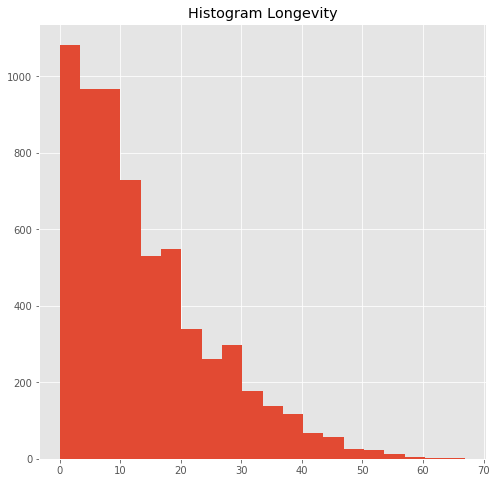

In [10]:
plt.hist(qwe['LONGEVITY'], bins=20) #change of number of bins to 20
plt.title('Histogram Longevity')
#data is sorted according to longevity

Text(0.5, 1.0, 'Histogram CHI')

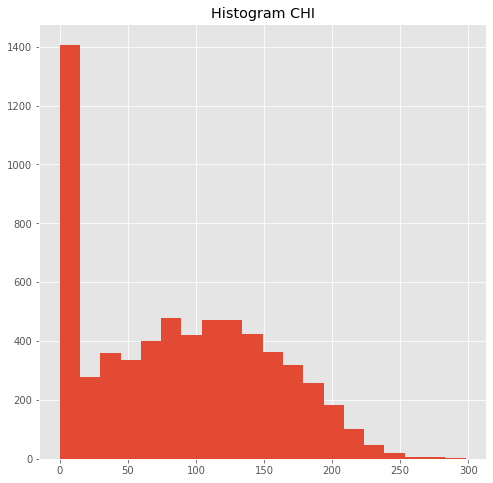

In [11]:
plt.hist(qwe['CHI_DEC'], bins=20) #change of number of bins to 20
plt.title('Histogram CHI')
#data is sorted according to longevity

Text(0.5, 1, 'Correlation between variables heat map')

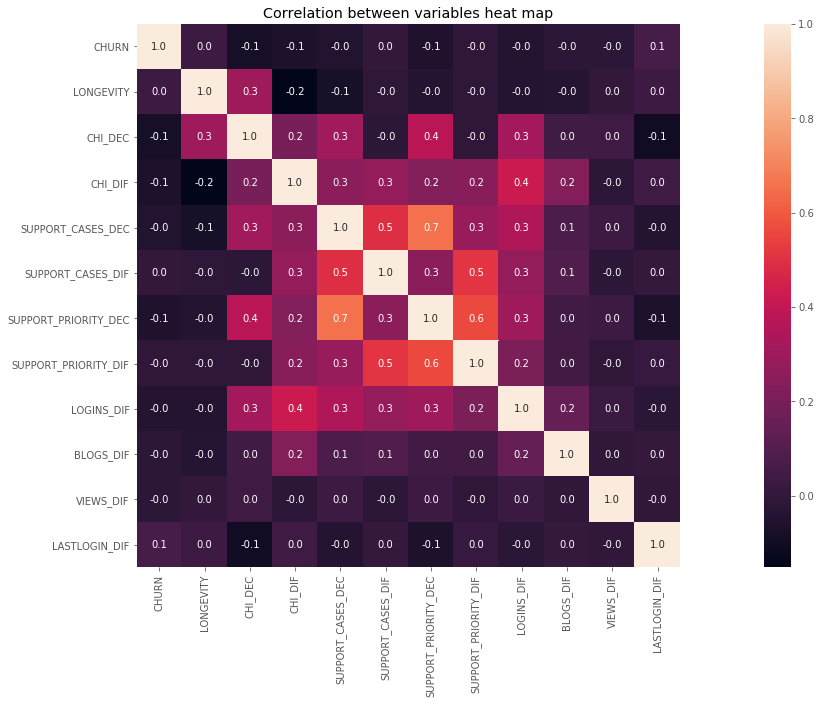

In [12]:
correlation = qwe.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(correlation, square=True, annot=True, fmt=".1f" )
plt.title('Correlation between variables heat map')

Subsetting to graph churn vs non-churn

Link of reference: https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

In [13]:
qwe['CHI_NOV'] = qwe['CHI_DEC'] - qwe['CHI_DIF']
chi_nov_col = qwe['CHI_NOV']
qwe.drop(labels = ['CHI_NOV'], axis=1,inplace = True)
qwe.insert(3, 'CHI_NOV', chi_nov_col)

qwe['SUPPORT_CASES_NOV'] = qwe['SUPPORT_CASES_DEC'] - qwe['SUPPORT_CASES_DIF']
sc_nov = qwe['SUPPORT_CASES_NOV']
qwe.drop(labels = ['SUPPORT_CASES_NOV'], axis=1,inplace = True)
qwe.insert(6, 'SUPPORT_CASES_NOV', sc_nov)

qwe['SUPPORT_PRIORITY_NOV'] = qwe['SUPPORT_PRIORITY_DEC'] - qwe['SUPPORT_PRIORITY_DIF']
sp_nov = qwe['SUPPORT_PRIORITY_NOV']
qwe.drop(labels = ['SUPPORT_PRIORITY_NOV'], axis=1,inplace = True)
qwe.insert(9, 'SUPPORT_PRIORITY_NOV', sp_nov)

#qwe.drop(labels = ['CHI_DIF'], axis=1,inplace = True)
#qwe.drop(labels = ['SUPPORT_CASES_DIF'], axis=1,inplace = True)
#qwe.drop(labels = ['SUPPORT_PRIORITY_DIF'], axis=1,inplace = True)

qwe

,CHURN,LONGEVITY,CHI_DEC,CHI_NOV,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_NOV,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_NOV,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF
0,0,67,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,31
1,0,67,62,58,4,0,0,0,0.0,0.0,0.0,0,0,-16,31
2,0,55,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,31
3,0,63,231,230,1,1,2,-1,3.0,3.0,0.0,167,-8,21996,0
4,0,57,43,44,-1,0,0,0,0.0,0.0,0.0,0,0,9,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
6343,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
6344,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0
6345,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0


In [14]:
#calculation of churn rate
non_churn = qwe['CHURN']== 0
qwe_non_churn = qwe[non_churn]

churn = qwe['CHURN']== 1
qwe_churn = qwe[churn]

rows = len(qwe['CHURN'])
churn_rate = (churn / rows) * 100
non_churn_rate = (non_churn / rows) * 100
print('The Churn Rate is =','%.2f'%churn_rate.sum(),'%')
print('The Non-Churn Rate is =','%.2f'%non_churn_rate.sum(),'%')

The Churn Rate is = 5.09 %
The Non-Churn Rate is = 94.91 %


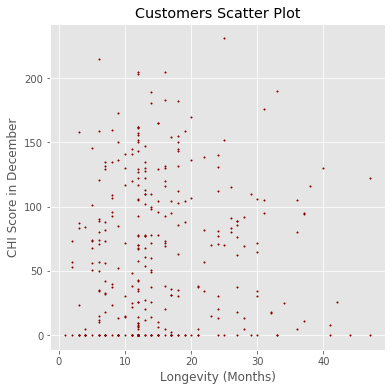

In [15]:
# Scatter plot for churn
x = qwe_churn['LONGEVITY']
y = qwe_churn['CHI_DEC']
plt.figure(figsize=(6,6))
#plt.xlim(0, 600000) # adjustment axis range after graphing  default and non default, without outliers and same scale
#plt.ylim(0, 600000)

# Use matplotlib to create the scatter plot using the two variables for the X and Y axes
plt.scatter(x,y,s=2,color='darkred')
plt.title('Customers Scatter Plot')
plt.xlabel('Longevity (Months)')
plt.ylabel('CHI Score in December')
plt.show()

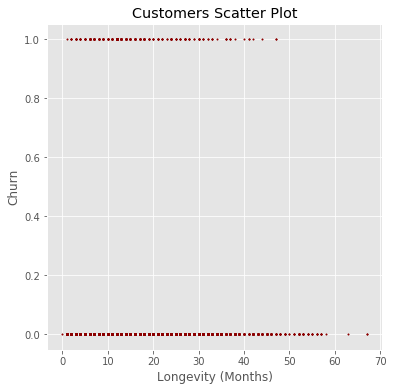

In [16]:
# Scatter plot longevity vs churn
x = qwe['LONGEVITY']
y = qwe['CHURN']
plt.figure(figsize=(6,6))
#plt.xlim(0, 600000) # adjustment axis range after graphing  default and non default, without outliers and same scale
#plt.ylim(0, 600000)

# Use matplotlib to create the scatter plot using the two variables for the X and Y axes
plt.scatter(x,y,s=2,color='darkred')
plt.title('Customers Scatter Plot')
plt.xlabel('Longevity (Months)')
plt.ylabel('Churn')
plt.show()

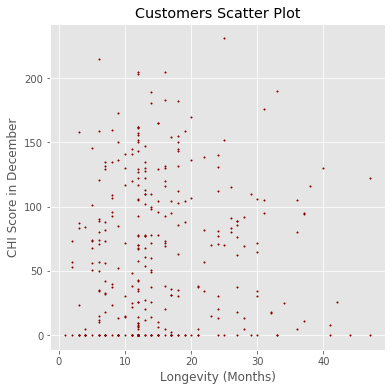

In [17]:
# Set of features
x = qwe_churn['LONGEVITY']
y = qwe_churn['CHI_DEC']
plt.figure(figsize=(6,6))
#plt.xlim(0, 600000) # adjustment axis range after graphing  default and non default, without outliers and same scale
#plt.ylim(0, 600000)

# Use matplotlib to create the scatter plot using the two variables for the X and Y axes
plt.scatter(x,y,s=2,color='darkred')
plt.title('Customers Scatter Plot')
plt.xlabel('Longevity (Months)')
plt.ylabel('CHI Score in December')
plt.show()

## 3. Feature engineering

In [18]:
#new feature created: total user usage: is the sum of all kind of interactions
qwe['USAGE'] = qwe['LOGINS_DIF'] + qwe['BLOGS_DIF']+ qwe['LASTLOGIN_DIF']
qwe

,CHURN,LONGEVITY,CHI_DEC,CHI_NOV,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_NOV,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_NOV,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF,USAGE
0,0,67,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,31,31
1,0,67,62,58,4,0,0,0,0.0,0.0,0.0,0,0,-16,31,31
2,0,55,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,31,31
3,0,63,231,230,1,1,2,-1,3.0,3.0,0.0,167,-8,21996,0,159
4,0,57,43,44,-1,0,0,0,0.0,0.0,0.0,0,0,9,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
6343,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
6344,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
6345,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0


In [19]:
#normalize the data
scaler = StandardScaler()
col_to_norm =['LONGEVITY','CHI_DEC','CHI_DIF','SUPPORT_CASES_DEC','SUPPORT_CASES_DIF','SUPPORT_PRIORITY_DEC',
                'SUPPORT_PRIORITY_DIF', 'LOGINS_DIF', 'BLOGS_DIF','VIEWS_DIF','LASTLOGIN_DIF','USAGE'] 

scaler.fit(qwe[col_to_norm]) #calculus of mean for transformation
qwe[col_to_norm] = scaler.transform(qwe[col_to_norm])#scaling and normalization of data

qwe[col_to_norm]
qwe

,CHURN,LONGEVITY,CHI_DEC,CHI_NOV,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_NOV,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_NOV,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF,USAGE
0,0,4.758693,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,1.627388,0.288504
1,0,4.758693,-0.381980,58,-0.034341,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.035630,1.627388,0.288504
2,0,3.683347,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,1.627388,0.288504
3,0,4.400244,2.167903,230,-0.131660,0.170366,2,-0.530827,1.656449,3.0,-0.020661,3.591818,-1.750391,6.947511,-0.098227,3.054630
4,0,3.862571,-0.668653,44,-0.196540,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.027699,1.627388,0.288504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,0,-1.155710,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,-0.098227,-0.381418
6343,0,-1.155710,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,-0.098227,-0.381418
6344,0,-1.155710,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,-0.098227,-0.381418
6345,0,-1.155710,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,-0.098227,-0.381418


## 4. Predictive Modeling and Evaluation

In [20]:
features = qwe.iloc[:,1:]
features.head()

,LONGEVITY,CHI_DEC,CHI_NOV,CHI_DIF,SUPPORT_CASES_DEC,SUPPORT_CASES_NOV,SUPPORT_CASES_DIF,SUPPORT_PRIORITY_DEC,SUPPORT_PRIORITY_NOV,SUPPORT_PRIORITY_DIF,LOGINS_DIF,BLOGS_DIF,VIEWS_DIF,LASTLOGIN_DIF,USAGE
0,4.758693,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,1.627388,0.288504
1,4.758693,-0.381980,58,-0.034341,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.035630,1.627388,0.288504
2,3.683347,-1.317440,0,-0.164100,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.030554,1.627388,0.288504
3,4.400244,2.167903,230,-0.131660,0.170366,2,-0.530827,1.656449,3.0,-0.020661,3.591818,-1.750391,6.947511,-0.098227,3.054630
4,3.862571,-0.668653,44,-0.196540,-0.409739,0,0.003706,-0.615544,0.0,-0.020661,-0.373445,-0.033741,-0.027699,1.627388,0.288504


In [21]:
#dependent variable
depvar = qwe.iloc[:,0]
depvar.head()

0    0
1    0
2    0
3    0
4    0
Name: CHURN, dtype: int64

In [22]:
x = features
y = depvar

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)

In [23]:
x_test.shape #confirmation of split

(1905, 15)

In [24]:
y_test #ground truth

3710    0
4767    0
3588    0
5129    0
5522    0
       ..
5961    0
86      0
3274    0
1655    0
1724    0
Name: CHURN, Length: 1905, dtype: int64

In [25]:
y_train.sum()

217

In [26]:
y_test.sum()
#this is 5.5% from the total; therefore the sets were balanced.

106

Building the models

In [58]:
#Logistic Regression
modelLOG.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
#Decision Tree Classifier
modelDTC.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
#Random Forest Classifier
modelRFC.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=12, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

6.7.Choosing the best model

Pass each trained model and the training sets to the function to obtain the training score. For single metric evaluation:

1st value: The score array for test scores on each cv split. (Higher is an indicator of a better performing model)

2nd value: The time for fitting the estimator on the train set for each cv split.

3rd value: The time for scoring the estimator on the test set for each cv split.

In [61]:
#Model Scoring: Logistic Regression
print(cross_val_score(modelLOG, x_train, y_train))
modelLOG.score(x_train,y_train)

[0.95050619 0.94938133 0.95157658 0.95157658 0.95157658]


0.9511481314723098

In [62]:
#Model Scoring: Decision Tree Classifier
print(cross_val_score(modelDTC, x_train, y_train))
modelDTC.score(x_train,y_train)

[0.89876265 0.90663667 0.90202703 0.91103604 0.91328829]


0.9981990094552003

In [63]:
#Model Scoring: Random Forest Classifier
print(cross_val_score(modelRFC, x_train, y_train))
modelRFC.score(x_train,y_train)

[0.95500562 0.95050619 0.95045045 0.94707207 0.9527027 ]


0.9981990094552003

Making predictions

In [64]:
#Predictions: Logistic Regression
predictionsLOG = modelLOG.predict(x_test)

In [65]:
#Predictions: Decision Tree Classifier
predictionsDTC = modelDTC.predict(x_test)

In [66]:
#Predictions: Random Forest Classifier
predictionsRFC = modelRFC.predict(x_test)

First evaluation of results

In [67]:
#Accuracy_score
predaccuracyLOG = accuracy_score(y_test,predictionsLOG)
predaccuracyDTC = accuracy_score(y_test,predictionsDTC)
predaccuracyRFC = accuracy_score(y_test,predictionsRFC)

#Classification error
predclasserrorLOG = 1-predaccuracyLOG
predclasserrorDTC = 1-predaccuracyDTC
predclasserrorRFC = 1-predaccuracyRFC

#ROC-AUC
predaucLOG = roc_auc_score(y_test,predictionsLOG)
predaucDTC = roc_auc_score(y_test,predictionsDTC)
predaucRFC = roc_auc_score(y_test,predictionsRFC)

#Precision
precisionLOG = precision_score(y_test,predictionsLOG)
precisionDTC = precision_score(y_test,predictionsDTC)
precisionRFC = precision_score(y_test,predictionsRFC)

#Recall
recallLOG = recall_score(y_test,predictionsLOG)
recallDTC = recall_score(y_test,predictionsDTC)
recallRFC = recall_score(y_test,predictionsRFC)

#F-1 Score
f1LOG = f1_score(y_test,predictionsLOG)
f1DTC = f1_score(y_test,predictionsDTC)
f1RFC = f1_score(y_test,predictionsRFC)

print("Comparison of models")

print(tabulate([['Logistic','%.3f'%predaccuracyLOG,'%.3f'%predclasserrorLOG,'%.3f'%predaucLOG,'%.3f'%precisionLOG,'%.3f'%recallLOG,'%.3f'%f1LOG],
                ['Decision Tree','%.3f'% predaccuracyDTC,'%.3f'% predclasserrorDTC,'%.3f'%predaucDTC,'%.3f'%precisionDTC,'%.3f'%recallDTC,'%.3f'%f1DTC],
                ['Random Forest','%.3f'% predaccuracyRFC,'%.3f'% predclasserrorRFC,'%.3f'%predaucRFC,'%.3f'%precisionRFC,'%.3f'%recallRFC,'%.3f'%f1RFC]], 
                 headers=['Model','Accuracy','Classification Error','ROC-AUC','Precision','Recall','f-1']))

Comparison of models
Model            Accuracy    Classification Error    ROC-AUC    Precision    Recall    f-1
-------------  ----------  ----------------------  ---------  -----------  --------  -----
Logistic            0.944                   0.056      0.5          0         0      0
Decision Tree       0.902                   0.098      0.54         0.13      0.132  0.131
Random Forest       0.943                   0.057      0.513        0.375     0.028  0.053


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Model Tuning

Model tuning #1

In [69]:
#Logistic - Model Tuning #1
modelLOG = LogisticRegression(solver='newton-cg',max_iter=100,random_state=12345,verbose=2,n_jobs=5)
modelLOG.fit(x_train,y_train)
print(cross_val_score(modelLOG, x_train, y_train,cv=4))
print(modelLOG.score(x_train,y_train))
predictionsLOG = modelLOG.predict(x_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[0.95139514 0.94959496 0.95135135 0.95135135]
0.9511481314723098


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished


In [70]:
#Decision Tree Classifier - Model Tuning #1
modelDTC = DecisionTreeClassifier(ccp_alpha=0.0,criterion='entropy',max_depth=4,splitter='best')
modelDTC.fit(x_train,y_train)
print(cross_val_score(modelDTC, x_train, y_train,cv=4))
print(modelDTC.score(x_train,y_train))
predictionsDTC = modelDTC.predict(x_test)

[0.94689469 0.94779478 0.94774775 0.95225225]
0.9520486267447096


In [71]:
#Random Forest Classifier - Model Tuning #1
RandomForestClassifier(max_depth=4,n_estimators=60,n_jobs=12) #estimators:number of trees
modelRFC.fit(x_train,y_train)
print(cross_val_score(modelRFC, x_train, y_train,cv=4))
print(modelRFC.score(x_train,y_train))
predictionsRFC = modelRFC.predict(x_test)

[0.95409541 0.95229523 0.94954955 0.94954955]
0.9981990094552003


In [72]:
#Accuracy_score
predaccuracyLOG = accuracy_score(y_test,predictionsLOG)
predaccuracyDTC = accuracy_score(y_test,predictionsDTC)
predaccuracyRFC = accuracy_score(y_test,predictionsRFC)

#Classification error
predclasserrorLOG = 1-predaccuracyLOG
predclasserrorDTC = 1-predaccuracyDTC
predclasserrorRFC = 1-predaccuracyRFC

#ROC-AUC
predaucLOG = roc_auc_score(y_test,predictionsLOG)
predaucDTC = roc_auc_score(y_test,predictionsDTC)
predaucRFC = roc_auc_score(y_test,predictionsRFC)

#Precision
precisionLOG = precision_score(y_test,predictionsLOG)
precisionDTC = precision_score(y_test,predictionsDTC)
precisionRFC = precision_score(y_test,predictionsRFC)

#Recall
recallLOG = recall_score(y_test,predictionsLOG)
recallDTC = recall_score(y_test,predictionsDTC)
recallRFC = recall_score(y_test,predictionsRFC)

#F-1 Score
f1LOG = f1_score(y_test,predictionsLOG)
f1DTC = f1_score(y_test,predictionsDTC)
f1RFC = f1_score(y_test,predictionsRFC)

print("Comparison of models")

print(tabulate([['Logistic','%.3f'%predaccuracyLOG,'%.3f'%predclasserrorLOG,'%.3f'%predaucLOG,'%.3f'%precisionLOG,'%.3f'%recallLOG,'%.3f'%f1LOG],
                ['Decision Tree','%.3f'% predaccuracyDTC,'%.3f'% predclasserrorDTC,'%.3f'%predaucDTC,'%.3f'%precisionDTC,'%.3f'%recallDTC,'%.3f'%f1DTC],
                ['Random Forest','%.3f'% predaccuracyRFC,'%.3f'% predclasserrorRFC,'%.3f'%predaucRFC,'%.3f'%precisionRFC,'%.3f'%recallRFC,'%.3f'%f1RFC]], 
                 headers=['Model','Accuracy','Classification Error','ROC-AUC','Precision','Recall','f-1']))

Comparison of models
Model            Accuracy    Classification Error    ROC-AUC    Precision    Recall    f-1
-------------  ----------  ----------------------  ---------  -----------  --------  -----
Logistic            0.944                   0.056      0.5          0         0      0
Decision Tree       0.942                   0.058      0.499        0         0      0
Random Forest       0.944                   0.056      0.513        0.429     0.028  0.053


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model tuning #2

In [74]:
#Logistic - Model Tuning #2
modelLOG = LogisticRegression(solver='lbfgs',max_iter=50,random_state=456,verbose=4,n_jobs=5)
modelLOG.fit(x_train,y_train)
print(cross_val_score(modelLOG, x_train, y_train,cv=4))
print(modelLOG.score(x_train,y_train))
predictionsLOG = modelLOG.predict(x_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[0.95139514 0.95049505 0.95135135 0.95135135]
0.9511481314723098


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished


In [75]:
#Decision Tree Classifier - Model Tuning #2
modelDTC = DecisionTreeClassifier(ccp_alpha=0.0,criterion='gini',max_depth=10)
modelDTC.fit(x_train,y_train)
print(cross_val_score(modelDTC, x_train, y_train,cv=4))
print(modelDTC.score(x_train,y_train))
predictionsDTC = modelDTC.predict(x_test)

[0.93969397 0.93969397 0.93153153 0.94414414]
0.9664565511031067


In [76]:
#Random Forest Classifier - Model Tuning #1
RandomForestClassifier(max_depth=7,n_estimators=100,n_jobs=10) #estimators:number of trees
modelRFC.fit(x_train,y_train)
print(cross_val_score(modelRFC, x_train, y_train,cv=3))
print(modelRFC.score(x_train,y_train))
predictionsRFC = modelRFC.predict(x_test)

[0.95408508 0.95273464 0.94864865]
0.9981990094552003


In [77]:
#Accuracy_score
predaccuracyLOG = accuracy_score(y_test,predictionsLOG)
predaccuracyDTC = accuracy_score(y_test,predictionsDTC)
predaccuracyRFC = accuracy_score(y_test,predictionsRFC)

#Classification error
predclasserrorLOG = 1-predaccuracyLOG
predclasserrorDTC = 1-predaccuracyDTC
predclasserrorRFC = 1-predaccuracyRFC

#ROC-AUC
predaucLOG = roc_auc_score(y_test,predictionsLOG)
predaucDTC = roc_auc_score(y_test,predictionsDTC)
predaucRFC = roc_auc_score(y_test,predictionsRFC)

#Precision
precisionLOG = precision_score(y_test,predictionsLOG)
precisionDTC = precision_score(y_test,predictionsDTC)
precisionRFC = precision_score(y_test,predictionsRFC)

#Recall
recallLOG = recall_score(y_test,predictionsLOG)
recallDTC = recall_score(y_test,predictionsDTC)
recallRFC = recall_score(y_test,predictionsRFC)

#F-1 Score
f1LOG = f1_score(y_test,predictionsLOG)
f1DTC = f1_score(y_test,predictionsDTC)
f1RFC = f1_score(y_test,predictionsRFC)

print("Comparison of models")

print(tabulate([['Logistic','%.3f'%predaccuracyLOG,'%.3f'%predclasserrorLOG,'%.3f'%predaucLOG,'%.3f'%precisionLOG,'%.3f'%recallLOG,'%.3f'%f1LOG],
                ['Decision Tree','%.3f'% predaccuracyDTC,'%.3f'% predclasserrorDTC,'%.3f'%predaucDTC,'%.3f'%precisionDTC,'%.3f'%recallDTC,'%.3f'%f1DTC],
                ['Random Forest','%.3f'% predaccuracyRFC,'%.3f'% predclasserrorRFC,'%.3f'%predaucRFC,'%.3f'%precisionRFC,'%.3f'%recallRFC,'%.3f'%f1RFC]], 
                 headers=['Model','Accuracy','Classification Error','ROC-AUC','Precision','Recall','f-1']))

Comparison of models
Model            Accuracy    Classification Error    ROC-AUC    Precision    Recall    f-1
-------------  ----------  ----------------------  ---------  -----------  --------  -----
Logistic            0.944                   0.056      0.5          0         0      0
Decision Tree       0.936                   0.064      0.518        0.2       0.047  0.076
Random Forest       0.944                   0.056      0.513        0.429     0.028  0.053


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 8. Model Evaluation

In [92]:
#Decision Tree Classifier
modelDTC.fit(x_train,y_train)

#Model Scoring: Decision Tree Classifier
print(cross_val_score(modelDTC, x_train, y_train))
modelDTC.score(x_train,y_train)

#Predictions: Decision Tree Classifier
predictionsDTC = modelDTC.predict(x_test)

predaccuracyDTC = accuracy_score(y_test,predictionsDTC)*100
predclasserrorDTC = (1-predaccuracyDTC)*100
predaucDTC = roc_auc_score(y_test,predictionsDTC)*100
precisionDTC = precision_score(y_test,predictionsDTC)*100
recallDTC = recall_score(y_test,predictionsDTC)*100
f1DTC = f1_score(y_test,predictionsDTC)*100

print('Final Metrics for Logistic Model:')
print('Accuracy:','%.2f'%predaccuracyDTC,'%')
print('AUC-ROC:','%.2f'%predaucDTC,'%')
print('Precision:','%.2f'%precisionDTC,'%')
print('Recall:','%.2f'%recallDTC,'%')
print('F1-Score:','%.2f'%f1DTC,'%')

[0.94150731 0.93813273 0.93355856 0.93581081 0.93918919]
Final Metrics for Logistic Model:
Accuracy: 93.70 %
AUC-ROC: 51.39 %
Precision: 18.18 %
Recall: 3.77 %
F1-Score: 6.25 %


In [88]:
from sklearn import metrics
print(metrics.classification_report(y_test,predictionsDTC))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1799
           1       0.21      0.06      0.09       106

    accuracy                           0.94      1905
   macro avg       0.58      0.52      0.53      1905
weighted avg       0.91      0.94      0.92      1905



In [95]:
#Calculations for confusion matrix and confirmation of metrics
prediction = pd.DataFrame(data = predictionsDTC)
prediction.columns = ['PREDICTION']

real = pd.DataFrame(data = y_test)
real.columns = ['REAL']
real = real.reset_index(drop = True)
merge = pd.concat([real,prediction], axis=1)

merge['SUM'] = merge['REAL']+ merge['PREDICTION']

def f(row):
    if row['SUM'] == 2:
        val = 'TrueP'
    elif row['SUM'] == 0:
        val = 'TrueN'
    elif row['REAL'] == 1:
        val = 'FalseN'
    else:
        val = 'FalseP'
    return val
merge['CATEGORY'] = merge.apply(f, axis=1)

TrueP = merge.loc[merge['CATEGORY'] == 'TrueP','CATEGORY'].count()
TrueN = merge.loc[merge['CATEGORY'] == 'TrueN','CATEGORY'].count()
FalseN = merge.loc[merge['CATEGORY'] == 'FalseN','CATEGORY'].count()
FalseP = merge.loc[merge['CATEGORY'] == 'FalseP','CATEGORY'].count()

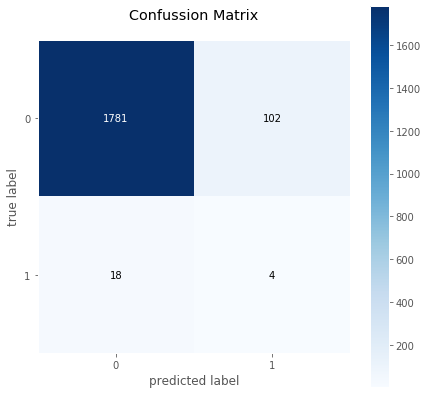

In [97]:
#Plot non-normalized confusion matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary = np.array([[TrueN, FalseN],
                   [FalseP, TrueP]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                figsize=(7, 7),
                                show_absolute=True,
                                colorbar=True)
plt.title('Confussion Matrix')
plt.show()

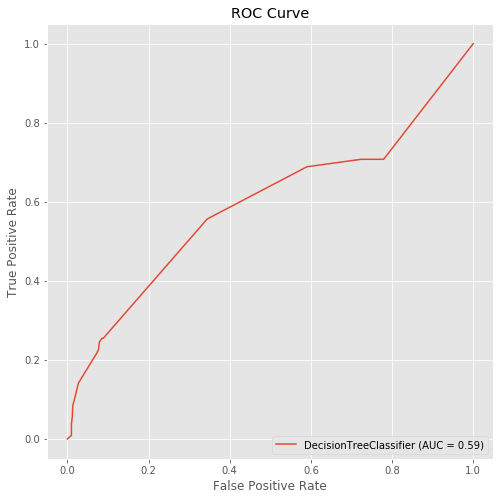

In [96]:
from sklearn.metrics import plot_roc_curve
svc_disp = plot_roc_curve(modelDTC, x_test, y_test)

plt.title('ROC Curve')
plt.show()